# objective

evaluate bid increment relative to item auction performance to try to find an optimal value to recommend to users

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# load data

In [2]:
# product, # of bids, bid increment, value, start $, end $
q = "select * from auctionitem"
df_ai = redshift_query_read(q, schema='production')

In [3]:
q = '''select
            ta.product,
            ta.total as price,
            ta.status as status,
            count(distinct(b.ticketholder)) as bidders,
            count(b.ticketholder) as bids,
            count(distinct(ta.id)) as transactions,
            count(distinct(ta.bidder)) as winners
        from bidders as b
            left join transauction as ta on b.product=ta.product
        group by ta.product, ta.total, ta.status'''
df_bids = redshift_query_read(q, schema='production')

In [4]:
df = df_ai.drop('id', axis=1).merge(df_bids, on='product')

In [5]:
df = df[(df['value']>0)&(df['bids']>1)]

# analysis

we will start by examining bid increments as a ratio or percentage of the item value

In [7]:
df['price_ratio'] = df['price'] / df['value']
df['bidincrement_ratio'] = df['bidincrement'] / df['value']

In [8]:
outperformers = df[df['price']>df['value']]
underperformers = df[df['price']<=df['value']]

print("{:,} ({:.1f}%) outperformers".format(len(outperformers), (len(outperformers) / len(df)) * 100.))
print("{:,} ({:.1f}%) underperformers".format(len(underperformers), (len(underperformers) / len(df)) * 100.))

3,334 (22.7%) outperformers
11,330 (77.3%) underperformers


# bid increment ratio

looking at the bid increment/value ratio or percentage of item value

In [9]:
ratios = [(0.0, 0.025), (0.025, 0.05), (0.05, 0.075), 
          (0.075, 0.10), (0.10, 0.15), (0.15, 0.20), 
          (0.20, 0.50), (0.50, 0.75), (0.75)]

In [10]:
# bucketing
print("All bid increment ratio sample sizes")

for i in ratios:
    try:
        len_items = len(df[(df['bidincrement_ratio']>=i[0])&(df['bidincrement_ratio']<i[1])])
        mdn = df[(df['bidincrement_ratio']>=i[0])&(df['bidincrement_ratio']<i[1])]['price_ratio'].median()
    except:
        len_items = len(df[df['bidincrement_ratio']>=i])
        mdn = df[df['bidincrement_ratio']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

All bid increment ratio sample sizes
(0.0, 0.025): 1,868 auction items; median price/value: 0.54
(0.025, 0.05): 2,876 auction items; median price/value: 0.60
(0.05, 0.075): 3,591 auction items; median price/value: 0.70
(0.075, 0.1): 1,771 auction items; median price/value: 0.77
(0.1, 0.15): 3,412 auction items; median price/value: 0.88
(0.15, 0.2): 448 auction items; median price/value: 0.94
(0.2, 0.5): 618 auction items; median price/value: 1.01
(0.5, 0.75): 8 auction items; median price/value: 3.00
0.75: 72 auction items; median price/value: 7.50


In [11]:
print("Outperformers bid increment ratio sample sizes")

for i in ratios:
    try:
        len_items = len(outperformers[(outperformers['bidincrement_ratio']>=i[0])&(outperformers['bidincrement_ratio']<i[1])])
        mdn = outperformers[(outperformers['bidincrement_ratio']>=i[0])&(outperformers['bidincrement_ratio']<i[1])]['price_ratio'].median()
    except:
        len_items = len(outperformers[outperformers['bidincrement_ratio']>=i])
        mdn = outperformers[outperformers['bidincrement_ratio']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

Outperformers bid increment ratio sample sizes
(0.0, 0.025): 210 auction items; median price/value: 1.22
(0.025, 0.05): 305 auction items; median price/value: 1.24
(0.05, 0.075): 672 auction items; median price/value: 1.22
(0.075, 0.1): 455 auction items; median price/value: 1.23
(0.1, 0.15): 1,135 auction items; median price/value: 1.30
(0.15, 0.2): 173 auction items; median price/value: 1.33
(0.2, 0.5): 309 auction items; median price/value: 1.40
(0.5, 0.75): 6 auction items; median price/value: 3.40
0.75: 69 auction items; median price/value: 8.00


In [12]:
print("Underperformers bid increment ratio sample sizes")

for i in ratios:
    try:
        len_items = len(underperformers[(underperformers['bidincrement_ratio']>=i[0])&(underperformers['bidincrement_ratio']<i[1])])
        mdn = underperformers[(underperformers['bidincrement_ratio']>=i[0])&(underperformers['bidincrement_ratio']<i[1])]['price_ratio'].median()
    except:
        len_items = len(underperformers[underperformers['bidincrement_ratio']>=i])
        mdn = underperformers[underperformers['bidincrement_ratio']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

Underperformers bid increment ratio sample sizes
(0.0, 0.025): 1,658 auction items; median price/value: 0.50
(0.025, 0.05): 2,571 auction items; median price/value: 0.56
(0.05, 0.075): 2,919 auction items; median price/value: 0.62
(0.075, 0.1): 1,316 auction items; median price/value: 0.67
(0.1, 0.15): 2,277 auction items; median price/value: 0.70
(0.15, 0.2): 275 auction items; median price/value: 0.75
(0.2, 0.5): 309 auction items; median price/value: 0.80
(0.5, 0.75): 2 auction items; median price/value: 1.00
0.75: 3 auction items; median price/value: 0.00


In [14]:
ops = pd.cut(outperformers['bidincrement_ratio'], bins=[r[0] for r in ratios[:-1]])
ups = pd.cut(underperformers['bidincrement_ratio'], bins=[r[0] for r in ratios[:-1]])

In [15]:
ops = ops.reset_index()['bidincrement_ratio'].value_counts().reset_index()
ups = ups.reset_index()['bidincrement_ratio'].value_counts().reset_index()
ops.columns = ['ratio', 'outperformers']
ups.columns = ['ratio', 'underperformers']
bi_ratios = ops.merge(ups, on='ratio')

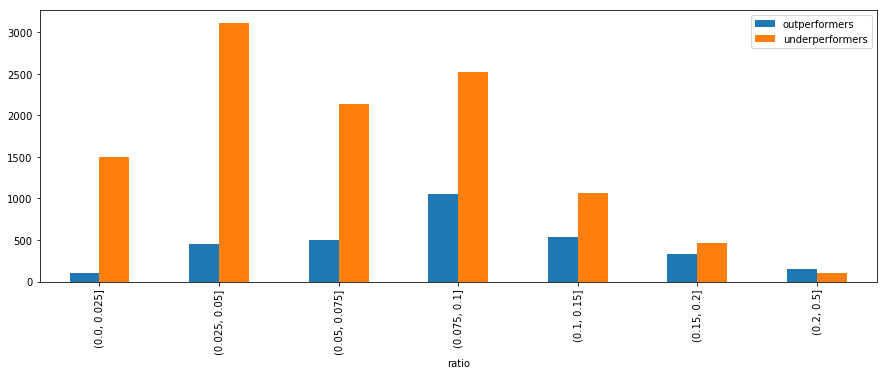

In [16]:
bi_ratios.sort_values('ratio').plot(x='ratio', figsize=(15,5), kind='bar')

charting raw counts. earlier peaks in the underperformers is clearly indicating that underperformers tend to use smaller bid increments relative the item value.

in order to more easily see the difference, we will normalize the sample sizes to see them in equal dimension.

In [17]:
bi_ratios['outperformers'] = bi_ratios['outperformers'] / bi_ratios['outperformers'].sum()
bi_ratios['underperformers'] = bi_ratios['underperformers'] / bi_ratios['underperformers'].sum()

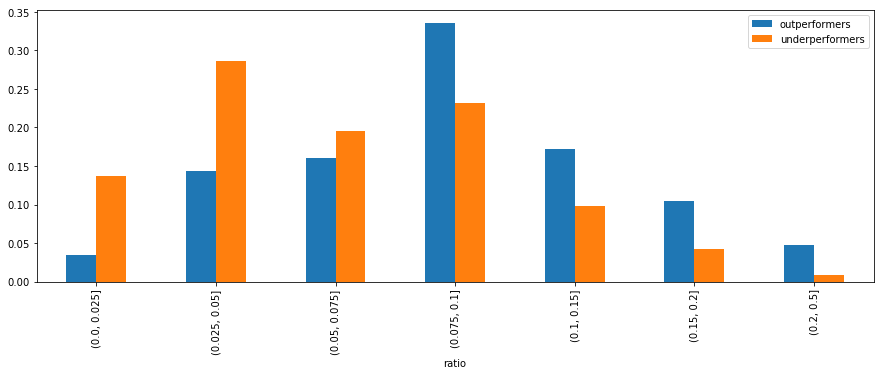

In [18]:
bi_ratios.sort_values('ratio').plot(x='ratio', figsize=(15,5), kind='bar')

normalized, it is clear to see that underperforming auction items have a tendency toward bid increments of 2.5% to 5% of the item value whereas the outperforming auction items have a tendency toward bid increments of 7.5% to 10% of the item value

__this is a good stat for a recommendation__

looking at all auction items, the median price/value ratio increases with an increase in the bid increment/value consistently

In [20]:
# examining specific bidincrement/value ratios
bidincrement_ratios = [(0.0, 0.025), (0.025, 0.05), (0.05, 0.075), 
          (0.075, 0.10), (0.10, 0.15), (0.15, 0.20), 
          (0.20, 0.50), (0.50, 0.75), (0.75)]
price_ratios = [0.0, 0.25, 0.50, 0.75, 1.0,
              1.25, 1.50, 2.0, 5.0, 10.0]

for i in bidincrement_ratios:
    print(i)
    
    try:
        items = df[(df['bidincrement_ratio']>=i[0])&(df['bidincrement_ratio']<i[1])]
    except:
        items = df[df['bidincrement_ratio']>=i]
        
    print(pd.cut(items['price_ratio'], bins=price_ratios).value_counts().reset_index().sort_values('index'))
        
    print()

(0.0, 0.025)
         index  price_ratio
3  (0.0, 0.25]          276
0  (0.25, 0.5]          556
1  (0.5, 0.75]          516
2  (0.75, 1.0]          294
4  (1.0, 1.25]          117
5  (1.25, 1.5]           38
6   (1.5, 2.0]           28
7   (2.0, 5.0]           22
8  (5.0, 10.0]            1

(0.025, 0.05)
         index  price_ratio
3  (0.0, 0.25]          181
1  (0.25, 0.5]          874
0  (0.5, 0.75]          915
2  (0.75, 1.0]          585
4  (1.0, 1.25]          163
5  (1.25, 1.5]           76
6   (1.5, 2.0]           40
7   (2.0, 5.0]           25
8  (5.0, 10.0]            1

(0.05, 0.075)
         index  price_ratio
6  (0.0, 0.25]           81
2  (0.25, 0.5]          765
0  (0.5, 0.75]         1202
1  (0.75, 1.0]          860
3  (1.0, 1.25]          360
4  (1.25, 1.5]          154
5   (1.5, 2.0]           96
7   (2.0, 5.0]           59
8  (5.0, 10.0]            3

(0.075, 0.1)
         index  price_ratio
7  (0.0, 0.25]           13
2  (0.25, 0.5]          278
0  (0.5, 0.75]     

there is a consistent intersection of peaking price/value ratio samples around 0.75 to 1.25 bid increment/value ratios. we still see a strong positive correlation between the two metrics but pushing greater bid increment/value ratios could have unforeseen negative effects if recommended universally. _a safe course of action would be to recommend a 10% bid increment/value ratio while never recommending to decrease the bid increment in cases that users feel greater values are desirable. over time, as this recommendation is applied, we will see a new floor develop at 10% and we can reassess with larger sample sizes._

# bid increment value

looking at the absolute value of bid increment (ie, $1, $5, etc.)

In [24]:
sets = [(0.0, 1.0), (1.0, 2.5), (2.5, 5.0), (5.0, 7.5),
       (7.5, 10.0), (10.0, 15.0), (15.0, 25.0), (25.0, 50.0),
       (50.0, 100.0), (100.0)]

### price/value ratio

In [26]:
print("All bid increment sample sizes")

for i in sets:
    try:
        len_items = len(df[(df['bidincrement']>=i[0])&(df['bidincrement']<i[1])])
        mdn = df[(df['bidincrement']>=i[0])&(df['bidincrement']<i[1])]['price_ratio'].median()
    except:
        len_items = len(df[df['bidincrement']>=i])
        mdn = df[df['bidincrement']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

All bid increment sample sizes
(0.0, 1.0): 577 auction items; median price/value: 0.71
(1.0, 2.5): 786 auction items; median price/value: 0.76
(2.5, 5.0): 387 auction items; median price/value: 0.80
(5.0, 7.5): 4,669 auction items; median price/value: 0.76
(7.5, 10.0): 70 auction items; median price/value: 0.80
(10.0, 15.0): 4,345 auction items; median price/value: 0.72
(15.0, 25.0): 1,389 auction items; median price/value: 0.69
(25.0, 50.0): 1,414 auction items; median price/value: 0.68
(50.0, 100.0): 665 auction items; median price/value: 0.67
100.0: 362 auction items; median price/value: 0.70


In [27]:
print("Underperformers bid increment sample sizes")

for i in sets:
    try:
        len_items = len(underperformers[(underperformers['bidincrement']>=i[0])&(underperformers['bidincrement']<i[1])])
        mdn = underperformers[(underperformers['bidincrement']>=i[0])&(underperformers['bidincrement']<i[1])]['price_ratio'].median()
    except:
        len_items = len(underperformers[underperformers['bidincrement']>=i])
        mdn = underperformers[underperformers['bidincrement']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

Underperformers bid increment sample sizes
(0.0, 1.0): 440 auction items; median price/value: 0.60
(1.0, 2.5): 574 auction items; median price/value: 0.63
(2.5, 5.0): 275 auction items; median price/value: 0.65
(5.0, 7.5): 3,496 auction items; median price/value: 0.65
(7.5, 10.0): 56 auction items; median price/value: 0.73
(10.0, 15.0): 3,411 auction items; median price/value: 0.63
(15.0, 25.0): 1,140 auction items; median price/value: 0.62
(25.0, 50.0): 1,142 auction items; median price/value: 0.60
(50.0, 100.0): 533 auction items; median price/value: 0.60
100.0: 263 auction items; median price/value: 0.55


In [28]:
print("Outperformers bid increment sample sizes")

for i in sets:
    try:
        len_items = len(outperformers[(outperformers['bidincrement']>=i[0])&(outperformers['bidincrement']<i[1])])
        mdn = outperformers[(outperformers['bidincrement']>=i[0])&(outperformers['bidincrement']<i[1])]['price_ratio'].median()
    except:
        len_items = len(outperformers[outperformers['bidincrement']>=i])
        mdn = outperformers[outperformers['bidincrement']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

Outperformers bid increment sample sizes
(0.0, 1.0): 137 auction items; median price/value: 1.25
(1.0, 2.5): 212 auction items; median price/value: 1.30
(2.5, 5.0): 112 auction items; median price/value: 1.30
(5.0, 7.5): 1,173 auction items; median price/value: 1.30
(7.5, 10.0): 14 auction items; median price/value: 1.41
(10.0, 15.0): 934 auction items; median price/value: 1.25
(15.0, 25.0): 249 auction items; median price/value: 1.25
(25.0, 50.0): 272 auction items; median price/value: 1.31
(50.0, 100.0): 132 auction items; median price/value: 1.40
100.0: 99 auction items; median price/value: 1.55


among the underperformers, price/value ratios appear to be random across all bid increment values. on the other hand, it does appear that among the outperformers a greater bid increment value will drive a greater price/value ratio. 

while this relationship does sppear consistent among the outperformers, i imagine that bid increment value needs to be largely dependent upon the auction item value. for instance, while statistically it does appear that 100 bid increments will drive the greatest price/value ratio, it may not be acceptable to auction bidders for an item worth less than 100.

### number of bids

In [30]:
print("All bid increment sample sizes")

for i in sets:
    try:
        len_items = len(df[(df['bidincrement']>=i[0])&(df['bidincrement']<i[1])])
        mdn = df[(df['bidincrement']>=i[0])&(df['bidincrement']<i[1])]['bids'].median()
    except:
        len_items = len(df[df['bidincrement']>=i])
        mdn = df[df['bidincrement']>=i]['bids'].median()
        
    print("{}: {:,} auction items; median bids: {:.2f}".format(i, len_items, mdn))

All bid increment sample sizes
(0.0, 1.0): 577 auction items; median bids: 11.00
(1.0, 2.5): 786 auction items; median bids: 10.00
(2.5, 5.0): 387 auction items; median bids: 6.00
(5.0, 7.5): 4,669 auction items; median bids: 7.00
(7.5, 10.0): 70 auction items; median bids: 6.00
(10.0, 15.0): 4,345 auction items; median bids: 6.00
(15.0, 25.0): 1,389 auction items; median bids: 6.00
(25.0, 50.0): 1,414 auction items; median bids: 6.00
(50.0, 100.0): 665 auction items; median bids: 6.00
100.0: 362 auction items; median bids: 7.00


In [31]:
print("Underperformers bid increment sample sizes")

for i in sets:
    try:
        len_items = len(underperformers[(underperformers['bidincrement']>=i[0])&(underperformers['bidincrement']<i[1])])
        mdn = underperformers[(underperformers['bidincrement']>=i[0])&(underperformers['bidincrement']<i[1])]['bids'].median()
    except:
        len_items = len(underperformers[underperformers['bidincrement']>=i])
        mdn = underperformers[underperformers['bidincrement']>=i]['bids'].median()
        
    print("{}: {:,} auction items; median bids: {:.2f}".format(i, len_items, mdn))

Underperformers bid increment sample sizes
(0.0, 1.0): 440 auction items; median bids: 11.00
(1.0, 2.5): 574 auction items; median bids: 8.00
(2.5, 5.0): 275 auction items; median bids: 5.00
(5.0, 7.5): 3,496 auction items; median bids: 6.00
(7.5, 10.0): 56 auction items; median bids: 6.00
(10.0, 15.0): 3,411 auction items; median bids: 5.00
(15.0, 25.0): 1,140 auction items; median bids: 5.00
(25.0, 50.0): 1,142 auction items; median bids: 5.00
(50.0, 100.0): 533 auction items; median bids: 5.00
100.0: 263 auction items; median bids: 5.00


In [32]:
print("Outperformers bid increment sample sizes")

for i in sets:
    try:
        len_items = len(outperformers[(outperformers['bidincrement']>=i[0])&(outperformers['bidincrement']<i[1])])
        mdn = outperformers[(outperformers['bidincrement']>=i[0])&(outperformers['bidincrement']<i[1])]['bids'].median()
    except:
        len_items = len(outperformers[outperformers['bidincrement']>=i])
        mdn = outperformers[outperformers['bidincrement']>=i]['bids'].median()
        
    print("{}: {:,} auction items; median bids: {:.2f}".format(i, len_items, mdn))

Outperformers bid increment sample sizes
(0.0, 1.0): 137 auction items; median bids: 15.00
(1.0, 2.5): 212 auction items; median bids: 16.00
(2.5, 5.0): 112 auction items; median bids: 9.00
(5.0, 7.5): 1,173 auction items; median bids: 11.00
(7.5, 10.0): 14 auction items; median bids: 13.00
(10.0, 15.0): 934 auction items; median bids: 10.00
(15.0, 25.0): 249 auction items; median bids: 10.00
(25.0, 50.0): 272 auction items; median bids: 11.00
(50.0, 100.0): 132 auction items; median bids: 10.00
100.0: 99 auction items; median bids: 14.00


__lower bid increments will drive more bids, but it levels out fairly quickly beyond 2__. Given the choice between 2 and 5, the average number of bids will have to be 2.5 times greater than the higher bid count in order to drive the same transaction amount. the numbers do not bear this out. in the underperformers, the greater bid increment values are about half that of the lower values and the outperformers are about 2/3.